# Validation of the PyPSA-Africa Installed capacity

This notebooks investigates the data quality of the African electric consumption
data by comparing PyPSA, official Nigerian and [IRENA statistics](https://pxweb.irena.org/pxweb/en/IRENASTAT/IRENASTAT__Power%20Capacity%20and%20Generation/ELECCAP_2022_cycle2.px/).

To reproduce the findings obtained in this notebook,
please run the full snakemake workflow for the Africa.
To do so, please set ``countries = ["Africa"]`` in the ``config.yaml`` file.

Note. An unoptimized prepared network is sufficient for this notebook. 

## Preparation

### Import packages

In [59]:
# import packages

import logging
import os

import pypsa
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

logger = logging.getLogger(__name__)

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 70)

### Set main directory to root folder

In [60]:
# set current folders
import sys

sys.path.append("../../")  # adds path to $ .../pypsa-africa
from scripts._helpers import sets_path_to_root

sets_path_to_root("pypsa-africa")  # moves path to root

This is the repository path:  /data/davidef/gitdf/pypsa-africa
Had to go 0 folder(s) up.


## 1. Load data 

#### IRENA data
Retrieved from [IRENA statistics](https://pxweb.irena.org/pxweb/en/IRENASTAT/IRENASTAT__Power%20Capacity%20and%20Generation/ELECCAP_2022_cycle2.px/).\
Please, download the statistics for 2020 for all the world and specify the url specified above.

In [61]:
from scripts._helpers import country_name_2_two_digits  # _helpers are from pypsa

year_select = 2020

IRENA_path = os.getcwd() + "/ELECCAP_20220804-155822.csv"
df_irena = pd.read_csv(IRENA_path, skiprows=2, encoding="latin-1")
df_irena = df_irena[df_irena.loc[:, "Year"] == year_select]
df_irena = df_irena.iloc[:, [0, 1, 2, 4]]
# df = df[df["iso_code"].notna()]  # removes antartica
df_irena["alpha2"] = df_irena.loc[:, "Country/area"].apply(
    lambda x: country_name_2_two_digits(x)
)
# electricity_demand_owid = df
# electricity_demand_owid.tail(2)

#### PyPSA generator data

Loads the PyPSA generators data

##### Load data from the network and create normalized dataframe

In [62]:
addelectricity_network_path = os.getcwd() + "/networks/elec.nc"
pypsa_network = pypsa.Network(addelectricity_network_path)

# statistics of non-storage units
installed_capacity_nostorages = pypsa_network.generators.copy()
# add country column
installed_capacity_nostorages["alpha2"] = installed_capacity_nostorages.bus.map(
    lambda x: pypsa_network.buses.country.loc[x]
)
installed_capacity_nostorages.loc[
    installed_capacity_nostorages["carrier"].isin(["ror"]), "carrier"
] = "hydro"
installed_capacity_nostorages.loc[
    installed_capacity_nostorages["carrier"] == "onwind", "carrier"
] = "onshore wind"
installed_capacity_nostorages.loc[
    installed_capacity_nostorages["carrier"].isin(["offwind-ac", "off-shore-dc"]),
    "carrier",
] = "offshore wind"
installed_capacity_nostorages.loc[
    installed_capacity_nostorages["carrier"].isin(["CCGT", "OCGT"]), "carrier"
] = "gas"
installed_capacity_nostorages.loc[
    installed_capacity_nostorages["carrier"] == "onwind", "carrier"
] = "wind"
installed_capacity_nostorages_select = installed_capacity_nostorages.loc[
    :, ["alpha2", "carrier", "p_nom"]
]

# statistics of storage units
installed_capacity_storages = pypsa_network.storage_units.copy()
# add country column
installed_capacity_storages["alpha2"] = installed_capacity_storages.bus.map(
    lambda x: pypsa_network.buses.country.loc[x]
)
installed_capacity_storages.loc[
    installed_capacity_storages["carrier"] == "PHS", "carrier"
] = "hydro"
installed_capacity_storages_select = installed_capacity_storages.loc[
    :, ["alpha2", "carrier", "p_nom"]
]


installed_capacity_raw = pd.concat(
    [installed_capacity_storages_select, installed_capacity_nostorages_select]
)
installed_capacity = installed_capacity_raw.groupby(["alpha2", "carrier"])[
    "p_nom"
].sum()
installed_capacity.groupby("carrier").sum()

INFO:pypsa.io:Imported network elec.nc has buses, carriers, generators, lines, links, loads, storage_units, transformers


carrier
biomass           217.837000
coal            29532.738536
gas             45401.031803
geothermal        147.300000
hydro           30760.702201
nuclear          1794.097153
oil             21583.174741
onshore wind     6407.303693
solar            9213.042628
Name: p_nom, dtype: float64

##### Load PyPSA powerplant data to crosscheck data from the network

In [63]:
powerplants_data = os.getcwd() + "/resources/powerplants.csv"
available_generators = pd.read_csv(powerplants_data)
installed_capacity_resources = available_generators.groupby(["Country", "Fueltype"])[
    "Capacity"
].sum()
installed_capacity_resources.groupby(["Fueltype"]).sum()

Fueltype
Bioenergy       217.837000
CCGT          15180.652692
Geothermal      147.300000
Hard Coal     29532.738536
Hydro         30546.923053
Nuclear        1794.097153
OCGT          30220.379111
Oil           21583.174741
Waste            67.098994
Name: Capacity, dtype: float64

# 2. Validate

#### Steps:
- Specify year of interest of the IRENA dataset and the countries of interest
- Harmonize IRENA dataset to the PyPSA standard
- Align dataframe naming and temporal resolution
- Merge dataframe


##### Specify year of the analysis and the countries of interest

In [64]:
year_owid = 2020  # option
country_list = installed_capacity_nostorages.alpha2.unique()
country_list

array(['ZA', 'MA', 'SD', 'BW', 'ER', 'SL', 'DZ', 'NG', 'RW', 'TN', 'EG',
       'GH', 'KE', 'ZM', 'CG', 'CI', 'EH', 'ZW', 'TZ', 'TG', 'UG', 'NE',
       'BJ', 'LY', 'ET', 'MG', 'CM', 'CF', 'GM', 'SN', 'GQ', 'AO', 'GW',
       'BF', 'DJ', 'MR', 'GN', 'LR', 'SZ', 'MW', 'GA', 'CD', 'SS', 'NA',
       'MZ', 'ML', 'TD', 'LS', 'BI', 'SO'], dtype=object)

##### Process IRENA data to match PyPSA standard

In [65]:
# copy IRENA dataset
df = df_irena.copy()

# Process technologies
df.loc[
    df["Technology"].isin(["Solar photovoltaic", "Solar thermal energy"]), "Technology"
] = "solar"
df.loc[df["Technology"].isin(["Onshore wind energy"]), "Technology"] = "onshore wind"
df.loc[df["Technology"].isin(["Offshore wind energy"]), "Technology"] = "offshore wind"
df.loc[
    df["Technology"].isin(
        ["Renewable hydropower", "Mixed Hydro Plants", "Pumped storage"]
    ),
    "Technology",
] = "hydro"
df.loc[
    df["Technology"].isin(["Other non-renewable energy", "Marine energy"]), "Technology"
] = "other"
df.loc[
    df["Technology"].isin(["Liquid biofuels", "Biogas", "Solid biofuels"]), "Technology"
] = "bioenergy"
df.loc[df["Technology"].isin(["Geothermal energy"]), "Technology"] = "geothermal"
df.loc[df["Technology"].isin(["Natural gas"]), "Technology"] = "gas"
df.loc[df["Technology"].isin(["Renewable municipal waste"]), "Technology"] = "waste"
df.loc[df["Technology"].isin(["Coal and peat"]), "Technology"] = "coal"
df.loc[df["Technology"].isin(["Oil", "Fossil fuels n.e.s."]), "Technology"] = "oil"


df = df[df.alpha2.isin(country_list)]
df["p_nom"] = pd.to_numeric(
    df["Installed electricity capacity by country/area (MW)"], errors="coerce"
)
installed_capacity_irena = (
    df.rename(columns={"Technology": "carrier"})
    .groupby(["alpha2", "carrier"])["p_nom"]
    .sum()
)
installed_capacity_irena.groupby("carrier").sum()

carrier
Nuclear            1940.000
bioenergy          1399.220
coal              47471.600
gas              100760.933
geothermal          870.300
hydro             33305.579
offshore wind         0.000
oil               24855.323
onshore wind       6390.634
other               100.000
solar              9267.112
waste                25.000
Name: p_nom, dtype: float64

##### Merge datasets by carrier

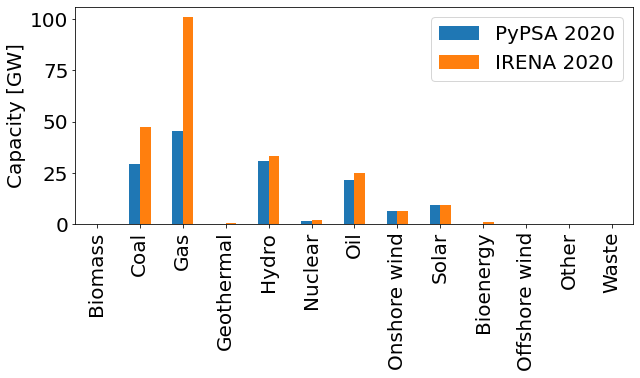

In [66]:
world_ic = installed_capacity_irena.groupby("carrier").sum() / 1000
world_ic.index = world_ic.index.str.capitalize()

world_pypsa = installed_capacity.groupby("carrier").sum() / 1000
if "load" in world_pypsa.index:
    world_pypsa = world_pypsa.drop("load")
world_pypsa.index = world_pypsa.index.str.capitalize()

world_compare = pd.concat(
    [world_pypsa.rename("PyPSA 2020"), world_ic.rename("IRENA 2020")], axis=1
)
ax = world_compare.plot.bar(
    ylabel="Capacity [GW]", xlabel="Technology", figsize=(10, 4)
).set(xlabel=None)

plt.savefig("capacity-validation-all.pdf", bbox_inches="tight")

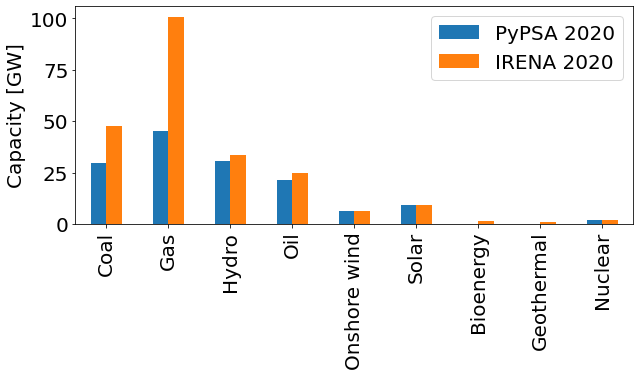

In [67]:
list_carriers = [
    "Coal",
    "Gas",
    "Hydro",
    "Oil",
    "Onshore wind",
    "Solar",
    "Bioenergy",
    "Geothermal",
    "Nuclear",
]

world_compare.loc[list_carriers].plot.bar(
    ylabel="Capacity [GW]", xlabel="Technology", figsize=(10, 4)
).set(xlabel=None)

plt.savefig("capacity-validation.pdf", bbox_inches="tight")

##### Merge dataframes by technology for specific country

According to [USAID](https://www.usaid.gov/powerafrica/nigeria), the total installed generation in Nigeria is:
- Hydro: 2.062 GW
- Gas: 11.972 GW
- Wind: 0.01 GW
- Solar: 0.007 GW
- Other/Diesel/HFO: 2.333 GW

Total: 16.384 GW

Power Africa new MW to date at financial close: 3.043 GW

In [68]:
# Get data from usaid manually
usaid_ng = pd.DataFrame(
    data=[2.062, 11.972, 0.01, 0.007, 2.333],
    index=["Hydro", "Gas", "Wind", "Solar", "Other/Diesel/HFO"],
    columns=["USAID"],
)

# Prepare data from usaid
usaid_ng.index.name = "carrier"

usaid_ng.rename(
    index={
        "Hydro": "hydro",
        "Gas": "gas",
        "Wind": "wind",
        "Solar": "solar",
        "Other/Diesel/HFO": "oil",
    },
    inplace=True,
)
print("WARNING: Other/Diesel/HFO is renamed to 'Oil'")

In [69]:
usaid_ng.head()

,USAID
carrier,
hydro,2.062
gas,11.972
wind,0.010
solar,0.007
oil,2.333


In [70]:
country = "NG"
country_ic = (
    installed_capacity_irena.iloc[
        installed_capacity_irena.index.get_level_values("alpha2") == country
    ]
    / 1000
)
country_pypsa = (
    installed_capacity.iloc[
        installed_capacity.index.get_level_values("alpha2") == country
    ]
    / 1000
)
country_compare = pd.concat(
    [country_pypsa.rename("PyPSA 2020"), country_ic.rename("IRENA 2020")], axis=1
)
country_compare.index = country_compare.index.get_level_values(1)
country_compare = pd.concat([country_compare, usaid_ng], axis=1)

Adjust the dataframe

In [71]:
country_compare

,PyPSA 2020,IRENA 2020,USAID
carrier,,,
gas,6.471930,10.95900,11.972
hydro,1.905414,2.11040,2.062
oil,1.222763,0.02300,2.333
onshore wind,0.001214,0.00000,NaN
solar,0.026262,0.00152,0.007
Nuclear,NaN,0.00000,NaN
bioenergy,NaN,0.00000,NaN
coal,NaN,0.00000,NaN
geothermal,NaN,0.00000,NaN


In [72]:
# Rename the index according to existing graph in paper
required_index = {
    # "coal": "Coal",
    "gas": "Gas",
    "hydro": "Hydro",
    "oil": "Oil",
    "wind": "Onshore wind",
    "solar": "Solar",
    # "Nuclear": "Nuclear",
    # "bioenergy": "Bioenergy",
    # "geothermal": "Geothermal",
}

country_compare.rename(index=required_index, inplace=True)

# select only required technologies
country_compare_sel = country_compare.loc[list(required_index.values())]

Plot the graph

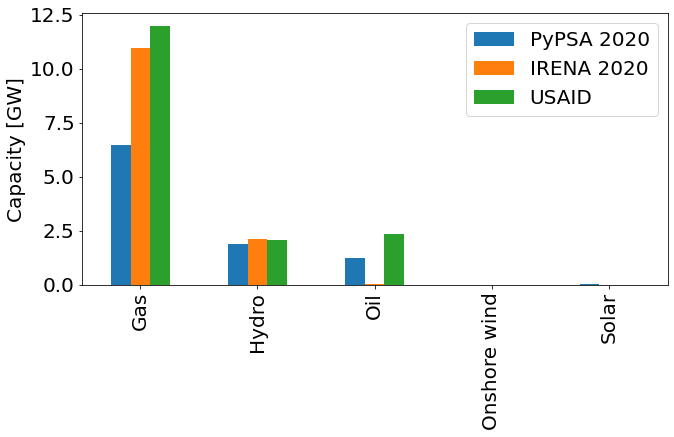

In [73]:
ax = country_compare_sel.plot.bar(ylabel="Capacity [GW]", xlabel="", figsize=(10.5, 5))
# optional:save it
ax.figure.savefig("capacity-validation-ng.pdf", bbox_inches="tight")

##### Merge dataframes by country

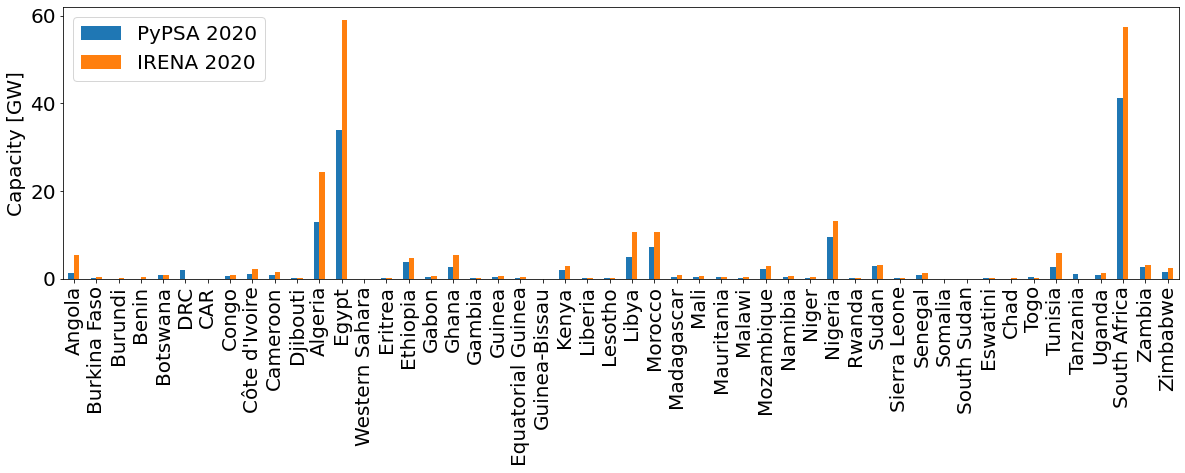

In [74]:
from scripts._helpers import two_digits_2_name_country

country_ic = (
    installed_capacity_irena[
        installed_capacity_irena.index.get_level_values(1)
        .str.capitalize()
        .isin(list_carriers)
    ]
    .groupby("alpha2")
    .sum()
    / 1000
)
country_pypsa = (
    installed_capacity[
        installed_capacity.index.get_level_values(1)
        .str.capitalize()
        .isin(list_carriers)
    ]
    .groupby("alpha2")
    .sum()
    / 1000
)

country_compare = pd.concat(
    [country_pypsa.rename("PyPSA 2020"), country_ic.rename("IRENA 2020")], axis=1
)
country_compare.index = pd.Series(
    country_compare.index.map(two_digits_2_name_country)
).replace(
    {
        "Congo, The Democratic Republic of the": "DRC",
        "Central African Republic": "CAR",
        "Tanzania, United Republic of": "Tanzania",
    }
)
plt.rcParams.update({"font.size": 20})
ax = country_compare.plot.bar(
    figsize=(20, 5), ylabel="Capacity [GW]", xlabel="Country", fontsize=20
)
ax.set(xlabel=None)

plt.savefig("capacity-validation-by-country.pdf", bbox_inches="tight")

In [75]:
# Installed capacities of a technology by country
# df[df.Technology=="gas"].groupby("alpha2")["p_nom"].sum()
# installed_capacity_nostorages_select[installed_capacity_nostorages_select.carrier == "gas"].groupby("alpha2")["p_nom"].sum()